In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [29]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [30]:
tf.keras.backend.clear_session()

In [31]:
subject = 'Amapá - Consumo de Cimento (t)'
start_index = 0
split_index = 179 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_AP.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Amapá - IDH,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Amapá - Consumo de Cimento (t),Amapá - PIB - Estadual,Amapá - PIB - Construção Civil,Amapá - PIB - Per Capita,Amapá - PIB - Preços de Mercado,Amapá - Desemprego
0,2003-1,0.711421,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,10.392,8.035813e+06,356591.003430,10.883143,7.033593e+06,8.514392
1,2003-2,0.711553,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,6.857,8.046432e+06,356647.711004,10.885206,7.037356e+06,8.508753
2,2003-3,0.711685,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,7.011,8.057052e+06,356704.418579,10.887268,7.041120e+06,8.503114
3,2003-4,0.711817,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,7.122,8.067671e+06,356761.126153,10.889331,7.044883e+06,8.497475
4,2003-5,0.711949,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,5.267,8.078290e+06,356817.833728,10.891394,7.048646e+06,8.491835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.208,NaN,NaN,NaN,NaN,NaN
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.476,NaN,NaN,NaN,NaN,NaN
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.236,NaN,NaN,NaN,NaN,NaN
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.549,NaN,NaN,NaN,NaN,NaN


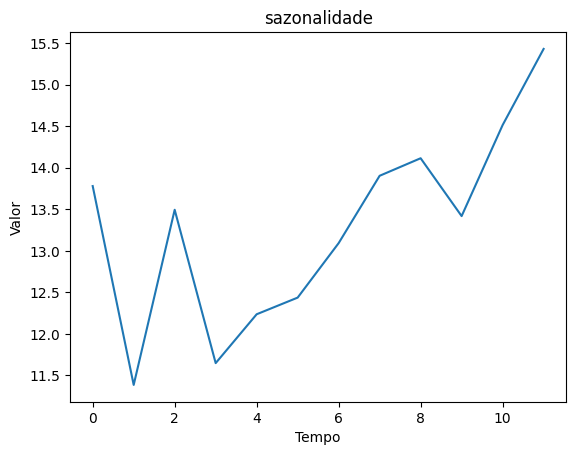

,sazonalidade
sazonalidade,
0,13.779893
1,11.385929
2,13.494500
3,11.648357
4,12.236643
5,12.437071
6,13.093071
7,13.903786
8,14.114929


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Amapá - IDH,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Amapá - PIB - Estadual,Amapá - PIB - Construção Civil,Amapá - PIB - Per Capita,Amapá - PIB - Preços de Mercado,Amapá - Desemprego,sazonalidade,Amapá - Consumo de Cimento (t)
0,2003-1,0.711421,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,8.035813e+06,356591.003430,10.883143,7.033593e+06,8.514392,13.779893,10.392
1,2003-2,0.711553,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,8.046432e+06,356647.711004,10.885206,7.037356e+06,8.508753,11.385929,6.857
2,2003-3,0.711685,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,8.057052e+06,356704.418579,10.887268,7.041120e+06,8.503114,13.494500,7.011
3,2003-4,0.711817,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,8.067671e+06,356761.126153,10.889331,7.044883e+06,8.497475,11.648357,7.122
4,2003-5,0.711949,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,8.078290e+06,356817.833728,10.891394,7.048646e+06,8.491835,12.236643,5.267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.903786,13.208
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.114929,13.476
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.418429,11.236
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.514071,13.549


In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      9.759
1      4.782
2      7.803
3      4.400
4      4.460
       ...  
235      NaN
236      NaN
237      NaN
238      NaN
239      NaN
Name: Amapá - Consumo de Cimento (t), Length: 240, dtype: float64

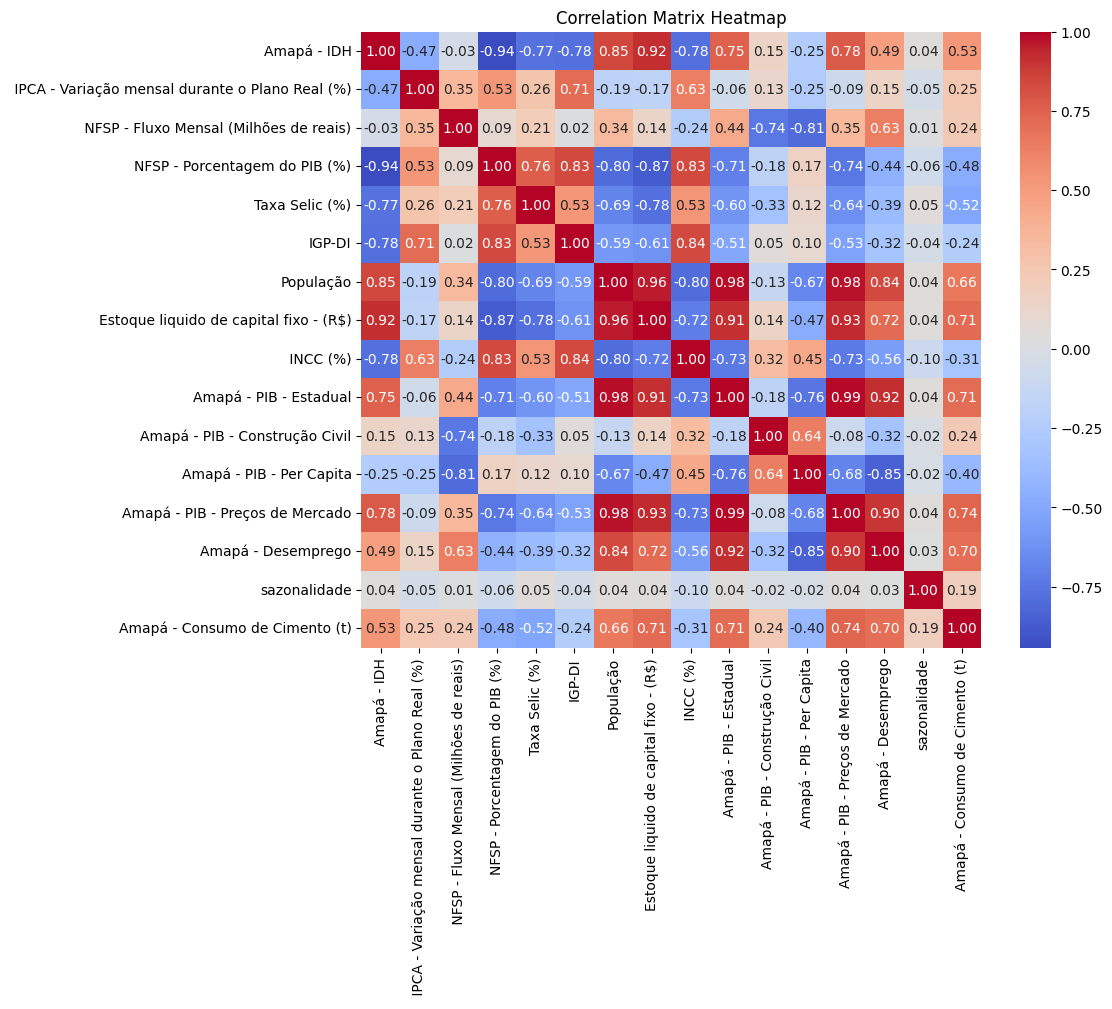

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Amapá - IDH,9.954376e+06
1,IPCA - Variação mensal durante o Plano Real (%),7.555105e+02
2,NFSP - Fluxo Mensal (Milhões de reais),1.945772e+02
3,NFSP - Porcentagem do PIB (%),2.165298e+02
4,Taxa Selic (%),5.312380e+01
5,IGP-DI,2.317165e+02
6,População,1.547488e+06
7,Estoque liquido de capital fixo - (R$),5.143268e+06
8,INCC (%),9.534463e+02
9,Amapá - PIB - Estadual,5.286854e+06


In [39]:
# data =data.drop(['Wind Gust (m/s)', 
#                  'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 3


,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,Estoque liquido de capital fixo - (R$),INCC (%),Amapá - PIB - Estadual,Amapá - PIB - Construção Civil,Amapá - PIB - Per Capita,Amapá - Desemprego,sazonalidade
0,0.724032,-5331.049150,11.520143,1.639718,1.036534,7.330309e+06,0.969649,8.035813e+06,356591.003430,10.883143,8.514392,13.779893
1,0.690297,-5318.079644,11.189862,1.378899,0.993449,7.335910e+06,0.950783,8.046432e+06,356647.711004,10.885206,8.508753,11.385929
2,0.669681,-5436.417870,10.820792,1.924317,0.973020,7.341511e+06,0.938332,8.057052e+06,356704.418579,10.887268,8.503114,13.494500
3,0.660494,-5707.015274,10.417840,1.331174,0.940489,7.347112e+06,0.926401,8.067671e+06,356761.126153,10.889331,8.497475,11.648357
4,0.648337,-5599.317941,9.959690,1.736072,0.917493,7.352713e+06,0.951683,8.078290e+06,356817.833728,10.891394,8.491835,12.236643
...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.366904,-5783.316460,2.206994,0.545067,0.471521,7.783063e+06,0.378150,9.678548e+06,348111.345937,10.818422,15.928514,13.903786
176,0.358935,-6001.730740,2.215328,0.782910,0.476827,7.780841e+06,0.377666,9.677692e+06,348171.145980,10.818111,15.905384,14.114929
177,0.354313,-6454.887704,2.232466,0.909682,0.475427,7.778619e+06,0.377838,9.676835e+06,348230.946024,10.817801,15.882255,13.418429
178,0.352728,-6243.191421,2.263185,1.050614,0.491301,7.776397e+06,0.370057,9.675978e+06,348290.746067,10.817490,15.859126,14.514071


In [40]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,Estoque liquido de capital fixo - (R$),INCC (%),Amapá - PIB - Estadual,Amapá - PIB - Construção Civil,Amapá - PIB - Per Capita,Amapá - Desemprego
0,0.604311,4.268118,2.039314,3.921218,-2.299937,3.214079,-1.664012,-0.636063,-0.368993,-0.825079
1,0.609431,4.096014,1.195209,3.582946,-2.263992,3.051841,-1.644695,-0.627297,-0.328615,-0.826659
2,0.562720,3.903698,2.960381,3.422548,-2.228047,2.944772,-1.625378,-0.618531,-0.288236,-0.828238
3,0.455907,3.693727,1.040752,3.167136,-2.192102,2.842174,-1.606061,-0.609765,-0.247858,-0.829818
4,0.498418,3.454992,2.351150,2.986591,-2.156157,3.059587,-1.586744,-0.600999,-0.207480,-0.831398
...,...,...,...,...,...,...,...,...,...,...
175,0.425789,-0.584804,-1.503380,-0.514871,0.605679,-1.872446,1.324249,-1.946873,-1.635773,1.251965
176,0.339575,-0.580461,-0.733634,-0.473208,0.591420,-1.876611,1.322691,-1.937629,-1.641857,1.245485
177,0.160702,-0.571531,-0.323353,-0.484199,0.577161,-1.875135,1.321132,-1.928385,-1.647940,1.239005
178,0.244264,-0.555524,0.132757,-0.359568,0.562902,-1.942040,1.319574,-1.919141,-1.654024,1.232526


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,Estoque liquido de capital fixo - (R$),INCC (%),Amapá - PIB - Estadual,Amapá - PIB - Construção Civil,Amapá - PIB - Per Capita,Amapá - Desemprego
0,0.604311,4.268118,2.039314,3.921218,-2.299937,3.214079,-1.664012,-0.636063,-0.368993,-0.825079
1,0.609431,4.096014,1.195209,3.582946,-2.263992,3.051841,-1.644695,-0.627297,-0.328615,-0.826659
2,0.562720,3.903698,2.960381,3.422548,-2.228047,2.944772,-1.625378,-0.618531,-0.288236,-0.828238
3,0.455907,3.693727,1.040752,3.167136,-2.192102,2.842174,-1.606061,-0.609765,-0.247858,-0.829818
4,0.498418,3.454992,2.351150,2.986591,-2.156157,3.059587,-1.586744,-0.600999,-0.207480,-0.831398
...,...,...,...,...,...,...,...,...,...,...
163,1.465326,-0.676734,0.472779,-1.087000,0.759879,-1.491033,1.308054,-1.856442,-1.624307,1.338092
164,1.351131,-0.668750,0.302784,-0.904679,0.749001,-1.525186,1.313475,-1.887469,-1.618083,1.329938
165,1.143146,-0.657609,0.339539,-0.900134,0.738124,-1.546744,1.318896,-1.918497,-1.611859,1.321784
166,1.542609,-0.647588,0.472795,-1.136836,0.727246,-1.586381,1.324317,-1.949525,-1.605636,1.313630


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0       9.759
1       4.782
2       7.803
3       4.400
4       4.460
        ...  
163     9.724
164    10.069
165    13.930
166    11.918
167    11.757
Name: Amapá - Consumo de Cimento (t), Length: 168, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 10)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split-window_size:split_index + 1]
test_input

,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,Estoque liquido de capital fixo - (R$),INCC (%),Amapá - PIB - Estadual,Amapá - PIB - Construção Civil,Amapá - PIB - Per Capita,Amapá - Desemprego
132,0.817451,-0.366715,-0.530011,0.174628,0.965586,-0.066954,1.001820,0.622503,-0.828458,1.153708
133,1.130195,-0.350285,-0.532694,0.240832,0.962419,-0.130652,1.014661,0.545479,-0.875843,1.169540
134,1.160498,-0.335122,-0.186421,0.176857,0.959252,-0.079602,1.027502,0.468455,-0.923227,1.185371
135,1.131990,-0.321950,-0.719664,-0.005233,0.956085,-0.034473,1.040344,0.391431,-0.970612,1.201202
136,1.384387,-0.302995,-0.798520,0.097576,0.952918,-0.177535,1.053185,0.314407,-1.017996,1.217033
137,1.375487,-0.290554,-0.612129,0.431487,0.949751,-0.208868,1.066026,0.237383,-1.065381,1.232864
138,1.438928,-0.281926,-0.476740,0.482414,0.946584,-0.245300,1.078868,0.160359,-1.112765,1.248696
139,1.569590,-0.275931,-0.211736,0.657043,0.943417,-0.333490,1.091709,0.083335,-1.160150,1.264527
140,1.584058,-0.271466,-0.484608,0.678386,0.940250,-0.296846,1.104551,0.006312,-1.207534,1.280358
141,1.166380,-0.273241,-0.183907,0.727143,0.937082,-0.292462,1.117392,-0.070712,-1.254919,1.296189


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 10)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(144, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[2904891099, 30530488, 116509922, 2959207842, 2573502977, 2588460823, 749767987, 2369693604, 4139889386, 4029113576]


Step: 0 ___________________________________________
val_loss: 1.8076550960540771
winner_seed: 2904891099


Step: 1 ___________________________________________
val_loss: 2.868835687637329


Step: 2 ___________________________________________
val_loss: 2.8854455947875977


Step: 3 ___________________________________________
val_loss: 1.645755410194397
winner_seed: 2959207842


Step: 4 ___________________________________________
val_loss: 2.330382823944092


Step: 5 ___________________________________________
val_loss: 4.5293660163879395


Step: 6 ___________________________________________
val_loss: 1.641176462173462
winner_seed: 749767987


Step: 7 ___________________________________________
val_loss: 2.6591033935546875


Step: 8 ___________________________________________
val_loss: 2.6321847438812256


Step: 9 ___________________________________________
val_loss: 2.101

In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 2963195227

Epoch 1/10000
4/4 [==============================] - 2s 117ms/step - loss: 221.3855 - val_loss: 25.7914
Epoch 2/10000
4/4 [==============================] - 0s 9ms/step - loss: 51.2924 - val_loss: 15.0330
Epoch 3/10000
4/4 [==============================] - 0s 9ms/step - loss: 27.2692 - val_loss: 16.3961
Epoch 4/10000
4/4 [==============================] - 0s 9ms/step - loss: 20.3339 - val_loss: 45.3515
Epoch 5/10000
4/4 [==============================] - 0s 9ms/step - loss: 33.5661 - val_loss: 5.7023
Epoch 6/10000
4/4 [==============================] - 0s 9ms/step - loss: 15.7160 - val_loss: 8.1440
Epoch 7/10000
4/4 [==============================] - 0s 8ms/step - loss: 11.9655 - val_loss: 5.1413
Epoch 8/10000
4/4 [==============================] - 0s 10ms/step - loss: 17.4718 - val_loss: 5.5741
Epoch 9/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.8954 - val_loss: 5.6440
Epoch 10/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.8562 - val_loss

4/4 [==============================] - 0s 9ms/step - loss: 6.3815 - val_loss: 5.0821
Epoch 164/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.4769 - val_loss: 4.6423
Epoch 165/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.4637 - val_loss: 4.7319
Epoch 166/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.5137 - val_loss: 4.7278
Epoch 167/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.3636 - val_loss: 4.4820
Epoch 168/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.9369 - val_loss: 4.7308
Epoch 169/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.7049 - val_loss: 4.6195
Epoch 170/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.4229 - val_loss: 4.5469
Epoch 171/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.8377 - val_loss: 4.9569
Epoch 172/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.5968 - val_loss: 4.5924
Epoch 

4/4 [==============================] - 0s 9ms/step - loss: 5.3360 - val_loss: 3.8804
Epoch 326/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.7491 - val_loss: 4.2334
Epoch 327/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.3520 - val_loss: 4.0710
Epoch 328/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.5925 - val_loss: 3.8494
Epoch 329/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.5883 - val_loss: 4.1629
Epoch 330/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.5622 - val_loss: 3.5479
Epoch 331/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.1981 - val_loss: 3.9803
Epoch 332/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.3552 - val_loss: 3.5901
Epoch 333/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.7075 - val_loss: 4.0222
Epoch 334/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.5922 - val_loss: 3.6832
Epoch 

4/4 [==============================] - 0s 9ms/step - loss: 4.3175 - val_loss: 3.8421
Epoch 488/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.6121 - val_loss: 3.0685
Epoch 489/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.7054 - val_loss: 3.0643
Epoch 490/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.4007 - val_loss: 2.9819
Epoch 491/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.8489 - val_loss: 3.1863
Epoch 492/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.3349 - val_loss: 3.2479
Epoch 493/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.9990 - val_loss: 3.3887
Epoch 494/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.3001 - val_loss: 2.9685
Epoch 495/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.7460 - val_loss: 3.0513
Epoch 496/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.5069 - val_loss: 3.0296
Epoch 

4/4 [==============================] - 0s 9ms/step - loss: 3.5632 - val_loss: 2.5766
Epoch 650/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.3910 - val_loss: 2.6653
Epoch 651/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.8539 - val_loss: 2.6774
Epoch 652/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.4491 - val_loss: 2.6447
Epoch 653/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.0548 - val_loss: 2.9660
Epoch 654/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.6908 - val_loss: 2.6955
Epoch 655/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.8250 - val_loss: 2.6400
Epoch 656/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.9764 - val_loss: 2.7137
Epoch 657/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.0221 - val_loss: 2.5508
Epoch 658/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.2801 - val_loss: 2.6022
Epoch 

4/4 [==============================] - 0s 9ms/step - loss: 2.7033 - val_loss: 2.2021
Epoch 812/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.7858 - val_loss: 2.1864
Epoch 813/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.6817 - val_loss: 2.3679
Epoch 814/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.1973 - val_loss: 2.1291
Epoch 815/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.7164 - val_loss: 2.2239
Epoch 816/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.0904 - val_loss: 2.3749
Epoch 817/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.1866 - val_loss: 2.1396
Epoch 818/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.8007 - val_loss: 2.3216
Epoch 819/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.7367 - val_loss: 2.0167
Epoch 820/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.6970 - val_loss: 2.2321
Epoch 

4/4 [==============================] - 0s 10ms/step - loss: 3.2562 - val_loss: 2.4724
Epoch 893/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.8429 - val_loss: 2.5838
Epoch 894/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.3187 - val_loss: 2.8492
Epoch 895/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.2451 - val_loss: 2.7111
Epoch 896/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.5558 - val_loss: 2.3188
Epoch 897/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.4176 - val_loss: 3.3476
Epoch 898/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.2215 - val_loss: 2.8558
Epoch 899/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.2420 - val_loss: 2.3673
Epoch 900/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.3964 - val_loss: 2.0237
Epoch 901/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.5261 - val_loss: 2.7272
E

Epoch 973/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.5495 - val_loss: 2.2393
Epoch 974/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.9975 - val_loss: 2.2301
Epoch 975/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.1900 - val_loss: 3.0298
Epoch 976/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.0655 - val_loss: 2.1833
Epoch 977/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.2088 - val_loss: 2.5673
Epoch 978/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.9702 - val_loss: 2.2347
Epoch 979/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.4267 - val_loss: 2.7827
Epoch 980/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.7715 - val_loss: 2.4999
Epoch 981/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.2659 - val_loss: 2.2072
Epoch 982/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.8067 - val_los

4/4 [==============================] - 0s 9ms/step - loss: 2.2925 - val_loss: 2.3976
Epoch 1134/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.4844 - val_loss: 2.0528
Epoch 1135/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.5151 - val_loss: 2.4641
Epoch 1136/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.7605 - val_loss: 2.1482
Epoch 1137/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.6026 - val_loss: 1.8662
Epoch 1138/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.3428 - val_loss: 2.2006
Epoch 1139/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.5380 - val_loss: 2.2695
Epoch 1140/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.6664 - val_loss: 2.4965
Epoch 1141/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.3877 - val_loss: 2.4607
Epoch 1142/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.3072 - val_loss: 2.

4/4 [==============================] - 0s 8ms/step - loss: 2.6833 - val_loss: 2.1049
Epoch 1294/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.8810 - val_loss: 1.9238
Epoch 1295/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.5685 - val_loss: 4.1086
Epoch 1296/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.6376 - val_loss: 2.6767
Epoch 1297/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.4636 - val_loss: 2.0939
Epoch 1298/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.5556 - val_loss: 2.2315
Epoch 1299/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.5140 - val_loss: 3.4246
Epoch 1300/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.4846 - val_loss: 2.3924
Epoch 1301/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.3627 - val_loss: 2.7364
Epoch 1302/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.7268 - val_loss: 2.58

4/4 [==============================] - 0s 9ms/step - loss: 2.0145 - val_loss: 2.3791
Epoch 1454/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.4448 - val_loss: 2.8783
Epoch 1455/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.0748 - val_loss: 2.8229
Epoch 1456/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.8082 - val_loss: 1.9692
Epoch 1457/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.9161 - val_loss: 1.9917
Epoch 1458/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.8929 - val_loss: 3.7553
Epoch 1459/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.5826 - val_loss: 3.5622
Epoch 1460/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.1786 - val_loss: 2.3425
Epoch 1461/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.8017 - val_loss: 2.1493
Epoch 1462/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.7667 - val_loss: 2.84

4/4 [==============================] - 0s 9ms/step - loss: 1.8189 - val_loss: 2.8844
Epoch 1614/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.8594 - val_loss: 2.5320
Epoch 1615/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.4805 - val_loss: 2.4079
Epoch 1616/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.9566 - val_loss: 2.6128
Epoch 1617/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.0887 - val_loss: 2.6799
Epoch 1618/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.8488 - val_loss: 2.5336
Epoch 1619/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.8488 - val_loss: 2.5580
Epoch 1620/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.7239 - val_loss: 2.6513
Epoch 1621/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.5646 - val_loss: 2.7786
Epoch 1622/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.7531 - val_loss: 2.4

In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 14ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,9.570232,9.484259,9.731879,9.688583,9.9315,10.099527,10.199181,10.290517,10.376319,10.4852,10.581103,10.642778
Target,9.691,7.378,6.97,7.612,8.442,8.835,11.251,11.342,13.11,13.195,10.053,12.274
Error,0.120768,2.106259,2.761879,2.076583,1.4895,1.264527,1.05182,1.051483,2.733681,2.7098,0.528103,1.631222


In [54]:
display(mae)
display(mape)

1.6271353

0.1726728

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 15ms/step
Ano-11: |Prediction[[121.08108]] - Target[120.15299999999999]| =  Error: [[0.9280777]]; MAPE:[[0.00772413]]


[array([[0.9280777]], dtype=float32)]

0.9280777

0.0077241324